In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from bayesianFunction import *

In [2]:
USE_DANISH_DATA = False
if USE_DANISH_DATA:
    data = pd.read_csv('data/DanishHousingMarket.csv')
    data = df_basic_process(data)
else:
    data = pd.read_csv('data/train.csv')
    

In [3]:
if USE_DANISH_DATA: 
    data['PriceLogged'] = list(np.log(np.array(list(data.priceCash)))) # log the price so it has a normal distribution
    X = data.drop(columns=['priceCash', 'PriceLogged'], errors='ignore')  # Drop target columns
else: 
    data['PriceLogged'] = list(np.log(np.array(list(data.SalePrice)))) # log the price so it has a normal distribution
    X = data.drop(columns=['SalePrice', 'PriceLogged'], errors='ignore')  # Drop target columns

y = data['PriceLogged']  # Use log-transformed price as target

# preprocess the data
X_df = preprocess_data(X=X, use_pca=False)

# # filter out the column which are not considered important
# if not USE_DANISH_DATA: 
#     important_features = find_best_features_with_lasso(X_df=X_df, y_df=y)
#     # important_features = ["GrLivArea", "OverallQual", "YearBuilt", "TotalBsmtSF"]
#     X_df = X_df[important_features]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)



Linear Regression Results:
Intercept: 8.6572
Mean Squared Error: 380789677857105.4375
R-squared: -2040525688772821.5000
Relative Error: 9223293.41%


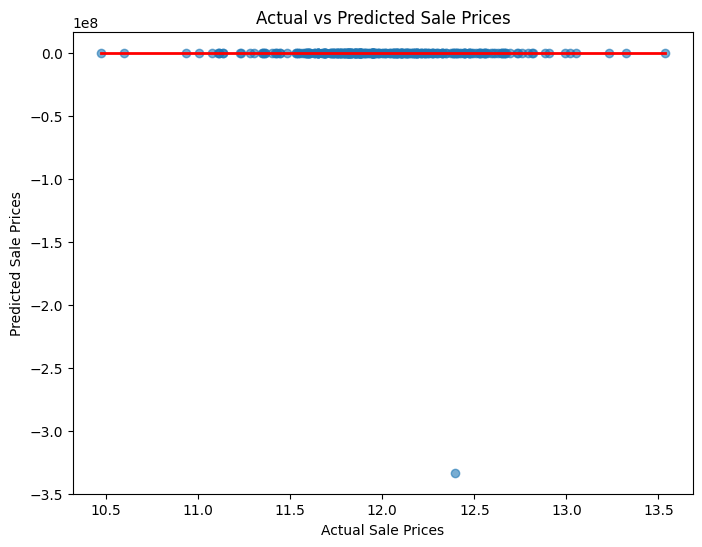

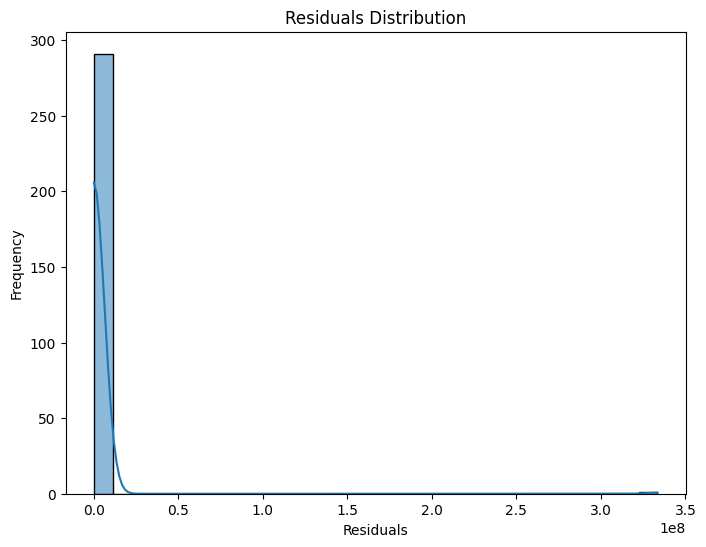


Shapiro-Wilk Test for Residual Normality: P-Value = 0.000
Residuals are not normally distributed.

Model Diagnostics and Results Completed!


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Train the Linear Regression Model
# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# 3. Model Performance and Diagnostics
print("\nLinear Regression Results:")
print(f"Intercept: {model.intercept_:.4f}")

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
relative_error = get_relative_error(y_true=np.array(list(y_test)), y_pred=y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Relative Error: {relative_error}%")


# 4. Compare Predictions with Actual Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Sale Prices')
plt.show()

# 5. Residual Diagnostics
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Shapiro-Wilk Test for Residual Normality
residual_stat, residual_p_value = stats.shapiro(residuals)
print(f"\nShapiro-Wilk Test for Residual Normality: P-Value = {residual_p_value:.3f}")
if residual_p_value < 0.05:
    print("Residuals are not normally distributed.")
else:
    print("Residuals are normally distributed.")

print("\nModel Diagnostics and Results Completed!")

Linear Regression Results with Log-Transformed Target:
Coefficient for 'GrLivArea': 0.0005
Intercept: 11.2468
Mean Squared Error (Log Scale): 0.0858
R-squared: 0.5402

Shapiro-Wilk Test for Residual Normality: P-Value = 0.000
Residuals are not normally distributed.

Model Diagnostics and Results Completed!

<h3>4.5 With Lasso


Cross-Validation R-squared Scores:
[0.88936985 0.84990582 0.761863   0.90877185 0.88186026]
Mean R-squared (CV): 0.8584

Lasso Regression Results:
Best Alpha: 0.001
Mean Squared Error (Log Scale): 26654.1850
R-squared: 0.9074
Relative Error: 10.31%


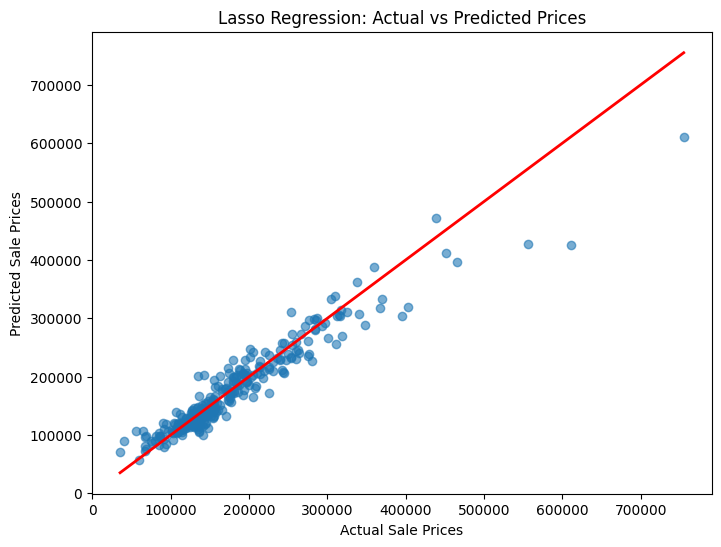


Top 10 Lasso Coefficients:
GrLivArea               0.100866
Neighborhood_StoneBr    0.092861
OverallQual             0.092068
Neighborhood_Crawfor    0.085583
Neighborhood_NridgHt    0.083775
Exterior1st_BrkFace     0.082066
CentralAir_Y            0.054231
Condition1_Norm         0.052964
Functional_Typ          0.052449
GarageCars              0.051795
dtype: float64


In [8]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}  # Regularization strengths
lasso_model = Lasso(max_iter=10000)  # Increase iterations for convergence
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Lasso model
best_lasso = grid_search.best_estimator_

# Cross-validation for evaluation
cv_scores = cross_val_score(best_lasso, X_train, y_train, cv=5, scoring='r2')
print("\nCross-Validation R-squared Scores:")
print(cv_scores)
print(f"Mean R-squared (CV): {np.mean(cv_scores):.4f}")

# Predict on test set
y_pred_lasso = best_lasso.predict(X_test)

# Back-transform predictions to original scale
y_pred_lasso_original = np.round(np.exp(y_pred_lasso))  # Revert log1p transformation
y_test_original = np.round(np.exp(y_test))

# Evaluate performance
rmse_lasso = np.sqrt(mean_squared_error(y_test_original, y_pred_lasso_original))
r2_lasso = r2_score(y_test_original, y_pred_lasso_original)
relative_error = get_relative_error(y_true=y_test_original, y_pred=y_pred_lasso_original)

print("\nLasso Regression Results:")
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Mean Squared Error (Log Scale): {rmse_lasso:.4f}")
print(f"R-squared: {r2_lasso:.4f}")
print(f"Relative Error: {relative_error}%")

# Compare predictions with actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_lasso_original, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         color='red', lw=2)  # Ideal 45-degree line
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Lasso Regression: Actual vs Predicted Prices')
plt.show()

# Print top 10 non-zero coefficients
lasso_coefficients = pd.Series(best_lasso.coef_, index=X_df.columns)
important_features = lasso_coefficients[lasso_coefficients != 0].sort_values(ascending=False)
top_10_coefficients = important_features.head(10)
print("\nTop 10 Lasso Coefficients:")
print(top_10_coefficients)


# Save to pickle file the important features to be used in the bayesian approach
with open("LassoImportantFeatures.pkl", "wb") as file:
    pickle.dump(list(important_features.index), file)


In [6]:
lasso_coefficients = pd.Series(best_lasso.coef_, index=X_df.columns)

# Identify dropped columns (coefficients set to zero)
dropped_columns = lasso_coefficients[lasso_coefficients == 0].index

print(len(dropped_columns))

print(f"Dropped Columns: {list(dropped_columns)}")

168
Dropped Columns: ['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'OpenPorchSF', 'MoSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'Street_Pave', 'Alley_Pave', 'LotShape_Reg', 'LandContour_Low', 'Utilities_NoSeWa', 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_CollgCr', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Feedr', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_Duplex', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseS

Lasso Coefficients:
GrLivArea      0.000269
OverallQual    0.110932
YearBuilt      0.003135
TotalBsmtSF    0.000117
dtype: float64

<h3>1. Bootstrapping Coefficients

In [24]:
from sklearn.utils import resample
from sklearn.linear_model import Lasso
import pandas as pd

# Set up variables
n_bootstraps = 100
alpha = grid_search.best_params_['alpha']  # Confidence level = 95% (2.5% on each tail)
coefficients_bootstrap = []
important_features = list(lasso_coefficients[lasso_coefficients != 0].index)

# Bootstrapping
for i in range(n_bootstraps):
    # Resample the training data with replacement
    X_boot, y_boot = resample(X_train, y_train, random_state=i)
    
    # Ensure X_boot retains the correct column structure
    X_boot = pd.DataFrame(X_boot, columns=X_train.columns)
    
    # Train Lasso model on bootstrap sample
    lasso_model_boot = Lasso(alpha=alpha, max_iter=10000)
    lasso_model_boot.fit(X_boot, y_boot)
    
    # Store coefficients
    coefficients_bootstrap.append(lasso_model_boot.coef_)

# Convert to DataFrame for easier analysis
coefficients_bootstrap = pd.DataFrame(coefficients_bootstrap, columns=list(X_train.columns))

# Calculate confidence intervals
lower_bounds = coefficients_bootstrap.quantile(alpha / 2)
upper_bounds = coefficients_bootstrap.quantile(1 - alpha / 2)

# Print confidence intervals for each feature
print("Bootstrapped Confidence Intervals for Lasso Coefficients:")
for feature in important_features:
    print(f"{feature}: [{lower_bounds[feature]:.6f}, {upper_bounds[feature]:.6f}]")


Bootstrapped Confidence Intervals for Lasso Coefficients:
Id: [-0.014006, 0.003880]
MSSubClass: [-0.041913, -0.000047]
LotFrontage: [-0.027178, 0.014843]
LotArea: [0.004148, 0.025498]
OverallQual: [0.058598, 0.110189]
OverallCond: [0.032354, 0.058881]
YearBuilt: [0.013660, 0.075687]
YearRemodAdd: [0.004073, 0.038505]
MasVnrArea: [-0.011214, 0.006716]
BsmtUnfSF: [0.000000, 0.016794]
1stFlrSF: [0.000000, 0.021590]
GrLivArea: [0.068648, 0.145833]
BsmtFullBath: [0.007408, 0.048847]
BsmtHalfBath: [-0.007175, 0.011247]
FullBath: [-0.000048, 0.029296]
HalfBath: [0.000068, 0.023263]
BedroomAbvGr: [-0.008638, 0.018639]
KitchenAbvGr: [-0.028587, 0.003438]
TotRmsAbvGrd: [0.000000, 0.045274]
Fireplaces: [0.012246, 0.036259]
GarageYrBlt: [-0.022664, 0.005159]
GarageCars: [0.009230, 0.075209]
GarageArea: [-0.013530, 0.046256]
WoodDeckSF: [0.004768, 0.026470]
EnclosedPorch: [-0.005307, 0.016261]
3SsnPorch: [0.000462, 0.017944]
ScreenPorch: [0.006237, 0.023062]
PoolArea: [-0.226256, 0.016891]
MiscVal:

Get the distribution of the coefficients for every sample, and get its paramters to use for the priors

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm

def is_normal_ks(data, alpha=0.05):
    # Test against a normal distribution
    # print(kstest(data, 'norm', args=(data.mean(), data.std())))
    stat, p = kstest(data, 'norm', args=(data.mean(), data.std()))
    # print(stat, p, alpha)
    return p > alpha  # Returns True if data is normal


counter = 0
priors_info = {}
# Visualize the distribution for each feature's coefficients
for feature in important_features:
    # sns.histplot(coefficients_bootstrap[feature], kde=True)
    # plt.title(f"Bootstrapped Distribution for {feature}")
    # plt.xlabel("Coefficient Value")
    # plt.ylabel("Frequency")
    # plt.show()

    normal_test = is_normal_ks(np.array(list(coefficients_bootstrap[feature])), alpha=0.05)

    if normal_test:
        mean = coefficients_bootstrap[feature].mean()
        std = coefficients_bootstrap[feature].std()
        priors_info[feature] = {"mean": mean, "std": std}     
    else:
        print(f'{feature} is not normal')
        priors_info[feature] = {"mean": 0, "std": 1}        

    counter += 1

# Print priors information
for feature, stats in priors_info.items():
    print(f"{feature}: Mean={stats['mean']:.4f}, Std={stats['std']:.4f}")


import json
# save the paramters as a json file so we can use in the bayesian script
with open("priors_info.json", "w") as file:
    json.dump(priors_info, file)



Bootstrapped Confidence Intervals for Lasso Coefficients:
GrLivArea: [0.000216, 0.000331]
OverallQual: [0.088705, 0.131872]
YearBuilt: [0.002720, 0.003594]
TotalBsmtSF: [0.000016, 0.000212]

In [12]:
r2_scores = []
mse_scores = []

# Bootstrapping metrics
for i in range(n_bootstraps):
    X_boot, y_boot = resample(X_train, y_train, random_state=i)
    lasso_model_boot = Lasso(alpha=grid_search.best_params_['alpha'], max_iter=10000)
    lasso_model_boot.fit(X_boot, y_boot)
    y_pred_boot = lasso_model_boot.predict(X_test)
    
    r2_scores.append(r2_score(y_test, y_pred_boot))
    mse_scores.append(mean_squared_error(y_test, y_pred_boot))

# Calculate confidence intervals
r2_lower, r2_upper = np.percentile(r2_scores, [2.5, 97.5])
mse_lower, mse_upper = np.percentile(mse_scores, [2.5, 97.5])

print(f"95% CI for R-squared: [{r2_lower:.4f}, {r2_upper:.4f}]")
print(f"95% CI for MSE: [{mse_lower:.4f}, {mse_upper:.4f}]")


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.804e+00, tolerance: 1.842e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.700e+00, tolerance: 1.721e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.113e+00, toleranc

95% CI for R-squared: [0.8250, 0.8893]
95% CI for MSE: [0.0207, 0.0327]


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.664e+00, tolerance: 1.980e-02
  model = cd_fast.enet_coordinate_descent(


95% CI for R-squared: [0.8052, 0.8448]
95% CI for MSE: [0.0290, 0.0364]

<h3>GPT-Optimized

Best Alpha: 0.0016768329368110084
RMSE (Log Scale): 0.1530
RMSE (Original Scale): 28067.15


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.547e+00, tolerance: 1.781e-02
  model = cd_fast.enet_coordinate_descent(


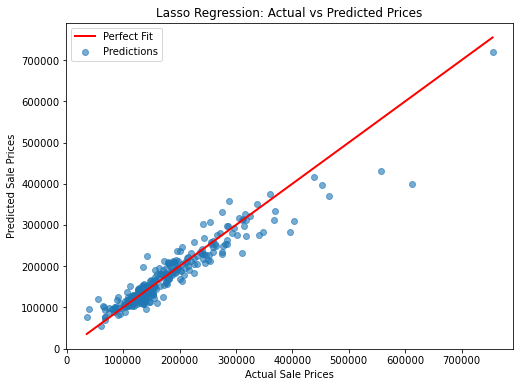

c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.109e+01, tolerance: 2.119e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+01, tolerance: 2.100e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e+01, toleranc

Mean CV RMSE (Log Scale): 0.1476


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+01, tolerance: 2.091e-02
  model = cd_fast.enet_coordinate_descent(


In [13]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Hyperparameter Tuning with Cross-Validation
param_grid = {'alpha': np.logspace(-4, 1, 50)}  # Finer range of alpha values
lasso_model = Lasso(max_iter=10000)
grid_search = GridSearchCV(lasso_model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_lasso = grid_search.best_estimator_

# Step 3: Model Performance
# Predict on test set
y_pred_lasso = best_lasso.predict(X_test)

# Evaluate RMSE on log scale
mse_lasso_log = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso_log = np.sqrt(mse_lasso_log)
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"RMSE (Log Scale): {rmse_lasso_log:.4f}")

# Back-transform predictions
y_pred_lasso_original = np.expm1(y_pred_lasso)
y_test_original = np.expm1(y_test)

# Calculate RMSE on original scale
rmse_lasso_original = np.sqrt(mean_squared_error(y_test_original, y_pred_lasso_original))
print(f"RMSE (Original Scale): {rmse_lasso_original:.2f}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_lasso_original, alpha=0.6, label='Predictions')
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], color='red', lw=2, label='Perfect Fit')
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Lasso Regression: Actual vs Predicted Prices')
plt.legend()
plt.show()

# Step 4: Cross-Validation Performance
cv_scores = cross_val_score(best_lasso, X, y, cv=10, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Mean CV RMSE (Log Scale): {cv_rmse.mean():.4f}")


Best Alpha: 0.0021209508879201904
RMSE (Log Scale): 0.1698
RMSE (Original Scale): 31813.14

Mean CV RMSE (Log Scale): 0.1693